## Utils

### XYZ to SMILES

In [3]:
from openbabel import openbabel as ob

conv = ob.OBConversion()
conv.SetInAndOutFormats("xyz", "smi")
mol = ob.OBMol()
conv.ReadFile(mol, "./test_mols/94_114_2_10 copy 2.xyz")
conv.WriteString(mol).split()[0]

'c1cc(cc2csnc12)c1cc2c(cc1)nncc2'

### Mol draw

In [4]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import display, Image

def draw_mols(mol):
    d2d = rdMolDraw2D.MolDraw2DCairo(300, 300)  # 使用Cairo绘制器
    opts = d2d.drawOptions()
    opts.addAtomIndices=True
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    
    # 获取绘图数据
    data = d2d.GetDrawingText()
    
    # 使用IPython的Image显示功能来展示图像
    display(Image(data=data, format='png'))

In [5]:
subunit_list = ["C12=CC=CC=C1C=C3C(C=CC=C3)=C2", "CC(C)C", "C12=CC=CC=C1C=CC=C2", "C1=CC=CC=C1", "C1(PC2=CC=CC=C2)=CC=CC=C1", 
                "CC(C=C1C)=CC=C1PC2=C(C)C=C(C)C=C2", "CC(C(OC)=C1C)=CC=C1PC2=C(C)C(OC)=C(C)C=C2", "CC(C(OC)=C1C)=CC=C1PC2=C(C)C(OC)=C(C)C=C2",
                "CC(C)C(C=C1)=C(OC)C(C(C)C)=C1PC2=CC=C(C(C)C)C(OC)=C2C(C)C", "CCCC(C(N(C)C)=C1CCC)=CC=C1PC2=C(CCC)C(N(C)C)=C(CCC)C=C2"]
index_list = [[4, 6, 12], [1], [4, 6], [0], [1], [8], [10], [10], [14], [15]]
subunit_dict = dict(zip(subunit_list, index_list))

group_list = ["C(=O)O", "CO", "CC(=O)C", "C=O", "C(=O)OC", "COC", "C=CC", "C#N", "C=NC", "CCl"]
index_list = [[0], [0], [0], [0], [3], [0], [2], [0], [0, 2], [0]]
group_dict = dict(zip(group_list, index_list))

combined_subunit_dict = {**subunit_dict, **group_dict}

### Reformat

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem

def mol_to_xyz(mol, file_path="mol.xyz"):
    """
    将RDKit分子对象转换为XYZ格式的字符串。
    :param mol: RDKit分子对象
    :return: XYZ格式的字符串
    """
    # 为分子生成3D构象
    # mol = Chem.AddHs(mol)  # 为分子添加氢原子
    # AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # 生成3D构象

    # 获取分子中原子的数量
    num_atoms = mol.GetNumAtoms()

    # 初始化XYZ内容
    xyz_content = f"{num_atoms}\n\n"

    # 遍历分子中的每个原子，添加它们的元素符号和坐标到XYZ内容
    conf = mol.GetConformer()
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        xyz_content += f"{atom.GetSymbol()} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}\n"
    with open(file_path, 'w+') as f:
        f.write(xyz_content)
        
import os
from openbabel import openbabel

def convert_xyz_to_gjf(folder_path):
    # 遍历文件夹中的所有文件
    for filename in os.listdir(folder_path):
        if filename.endswith(".xyz"):
            # 设置输入和输出格式
            obConversion = openbabel.OBConversion()
            obConversion.SetInAndOutFormats("xyz", "gjf")

            # 读取XYZ文件
            mol = openbabel.OBMol()
            input_file = os.path.join(folder_path, filename)
            obConversion.ReadFile(mol, input_file)
            input_name = os.path.splitext(os.path.basename(input_file))[0]
            # 设置GJF文件的关键字
            gjf_keywords = f"%nprocshared=40\n%mem=80GB\n%chk={input_name}.chk\n#p opt freq m062x def2svp\n\nTitle Card Required\n"
            obConversion.AddOption("k", openbabel.OBConversion.OUTOPTIONS, gjf_keywords)

            # 写入GJF文件
            output_file = input_file.replace(".xyz", ".gjf")
            obConversion.WriteFile(mol, output_file)
            os.system(f"bash /home/wangxi/ligands_library/test_mols/fix_openbabel_output.sh {output_file}")

### Connect mols via atom indice

In [7]:
from rdkit import Chem
from rdkit.Chem import rdchem, rdmolops

def connect_mols(mol_a, mol_b, atom_index1, atom_index2, addhs_flag=True):
    # 将两个待连接分子置于同一个对象中
    merged_mol = Chem.CombineMols(mol_a, mol_b)
    ed_merged_mol = Chem.EditableMol(merged_mol)

    # 计算合并后分子中原子b的实际索引
    num_atoms_a = mol_a.GetNumAtoms()
    atom_index2 += num_atoms_a  # 更新b的位置，因为它现在是合并分子的一部分

    # 在两个待连接位点之间加入单键连接
    try:
        ed_merged_mol.AddBond(atom_index1, atom_index2, order=rdchem.BondType.SINGLE)
    except:
        print(atom_index1)
        print(atom_index2)
        draw_mols(ed_merged_mol.GetMol())
    mol_connected = ed_merged_mol.GetMol()
    
    if addhs_flag:
        try:
            mol_connected.UpdatePropertyCache(strict=True) 
            mol_connected = Chem.AddHs(mol_connected)
            AllChem.EmbedMolecule(mol_connected, AllChem.ETKDG())
        except:
            return None, None, None
    
    return mol_connected, atom_index1, atom_index2

def connect_possible_R_group(mol, subunit_dict, atom_index):
    unsaturated_atoms = []
    mol_list = []
    code_list = []
    for atom in mol.GetAtoms():
        if atom.GetImplicitValence() > 0:
            unsaturated_atoms.append(atom.GetIdx()) 
    unsaturated_atoms.remove(atom_index)
    
    for group_index, group in enumerate(list(subunit_dict.keys())):
        for backbone_index in unsaturated_atoms:
            for index in subunit_dict[group]:
                # Read mol from SMILES
                group_mol = Chem.MolFromSmiles(group)
                # Remove Hs
                rdmolops.RemoveHs(mol)
                rdmolops.RemoveHs(group_mol)
                # Connect mols
                mol_connected, _, _ = connect_mols(mol, group_mol, backbone_index, index, addhs_flag=False)
                if mol_connected is not None:
                    mol_list.append(mol_connected)
                    code_list.append(f"R{group_index}B{backbone_index}G{index}")
    return mol_list, code_list

### Make lib

In [8]:
from fragments_dict import smiles_rings
all_mols = list(smiles_rings.keys())

In [9]:
# Select mols via molecular weight
from rdkit.Chem import Descriptors
import random

# 计算每个SMILES的相对原子质量
weights = [(smi, Descriptors.MolWt(Chem.MolFromSmiles(smi))) for smi in all_mols]

# 按相对原子质量排序
sorted_weights = sorted(weights, key=lambda x: x[1], reverse=True)

# 取最大的前20个分子，最小的前10个分子
top_20 = sorted_weights[:20]
bottom_10 = sorted_weights[-10:]

# 从剩余的分子中随机抽取10个
remaining = [item for item in sorted_weights if item not in top_20 and item not in bottom_10]
selected_random_10 = random.sample(remaining, 10)

# 合并为新的列表并提取SMILES编码
all_mols_reduced = [item[0] for item in top_20 + bottom_10 + selected_random_10]

In [11]:
counts = 0
processed_files = set()
directory_to_save = "./mols_with_subunit"

for i in range(len(all_mols_reduced)):
    for j in range(i+1, len(all_mols_reduced)):
        smiles_a = all_mols[i]
        smiles_b = all_mols[j]
        
        mol_a = Chem.MolFromSmiles(smiles_a)
        mol_b = Chem.MolFromSmiles(smiles_b)
        
        index_list_a = smiles_rings[smiles_a][1]
        index_list_b = smiles_rings[smiles_b][1]
        
        for index_a in index_list_a:
            for index_b in index_list_b:
                
                mols_a_with_R, code_list_a = connect_possible_R_group(mol_a, combined_subunit_dict, index_a)
                mols_b_with_R, code_list_b = connect_possible_R_group(mol_b, combined_subunit_dict, index_b)
                
                for R_index_a, mol_a in enumerate(mols_a_with_R):
                    for R_index_b, mol_b in enumerate(mols_b_with_R):
                        mol_connected, atom_index_a, atom_index_b = connect_mols(mol_a, mol_b, index_a, index_b)
                        if mol_connected is not None:
                            try:
                                mol_to_xyz(mol_connected, os.path.join(directory_to_save, f"{i}-{code_list_a[R_index_a]}_{j}-{code_list_b[R_index_b]}_{atom_index_a}_{atom_index_b}.xyz"))
                                counts += 1
                            except:
                                continue

[17:49:57] Explicit valence for atom # 25 C, 5, is greater than permitted
[17:49:57] Explicit valence for atom # 25 C, 5, is greater than permitted
[17:49:57] Explicit valence for atom # 25 C, 5, is greater than permitted
[17:49:57] Explicit valence for atom # 25 C, 5, is greater than permitted
[17:49:58] Explicit valence for atom # 25 C, 5, is greater than permitted
[17:49:58] Explicit valence for atom # 25 C, 5, is greater than permitted
[17:49:58] Explicit valence for atom # 25 C, 5, is greater than permitted
[17:49:59] Explicit valence for atom # 25 C, 5, is greater than permitted
[17:49:59] Explicit valence for atom # 25 C, 5, is greater than permitted
[17:50:00] Explicit valence for atom # 25 C, 5, is greater than permitted
[17:50:01] Explicit valence for atom # 25 C, 5, is greater than permitted
[17:50:03] Explicit valence for atom # 25 C, 5, is greater than permitted
[17:50:03] Explicit valence for atom # 25 C, 5, is greater than permitted
[17:50:03] Explicit valence for atom #

## Calculation

In [ ]:
import os

def cal_torsion_profile_via_xtb(xyz_input):
    xyz_input_base = os.path.basename(xyz_input)
    xyz_id = os.path.basename(xyz_input).split(".")[0]
    
    index_a, index_b = int(xyz_id.split("_")[2]), int(xyz_id.split("_")[3])
    index_a_adj = index_a + 1
    index_b_adj = index_b - 1
    
    dihedral_indices = f"{index_a_adj + 1},{index_a + 1},{index_b + 1},{index_b_adj + 1}"
    
    workdir_dir = f"./torsion_profiles/{xyz_id}"
    workdir_dir = os.path.abspath(workdir_dir)
    os.makedirs(workdir_dir, exist_ok=True)
    
    with open(f"{workdir_dir}/xtb_input", "w") as f:
        f.write(f"$constrain\nforce constant=0.05\n$scan\ndihedral: {dihedral_indices},0.0; 0.0,360.0,36\n$end")
    
    os.system(f"cp {xyz_input} {workdir_dir}")
    os.system(f"cd {workdir_dir} && xtb {xyz_input_base} --input xtb_input --opt loose")

In [ ]:
all_xyz = os.listdir("./nacked_mols")
path_test = os.path.join("./nacked_mols", all_xyz[0])

In [ ]:
path_test

'./nacked_mols/94_114_2_10.xyz'

In [ ]:
cal_torsion_profile_via_xtb(path_test)

      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.6.1 (8d0f1dd) compiled by 'conda@1efc2f54142f' on 2023-08-01

   xtb is free software: you can redistribute it and/or modify it under
   the terms of the GNU Lesser General Public License as published by
   the Free Software Foundation, either version 3 of the License, or
   (at your option) any later version.
   
   xtb is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY; w

normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


In [ ]:
import numpy as np

def calculate_dihedral(coords, index):
    # Ensure there are enough atoms to calculate the dihedral
    if len(coords) < index[3] + 1:
        return None
    
    # Extracting the four atoms for dihedral calculation
    p0, p1, p2, p3 = [np.array(coords[index[i]]) for i in range(4)]

    # Vectors between the atoms
    b0 = -1.0 * (p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2

    # Normal vectors
    b0xb1 = np.cross(b0, b1)
    b1xb2 = np.cross(b1, b2)

    # Normalize b1
    b1 /= np.linalg.norm(b1)

    # Calculate the angle between b0xb1 and b1xb2
    m0 = np.cross(b0xb1, b1)
    m1 = np.cross(b0, b1xb2)
    dihedral = np.arctan2(np.linalg.norm(np.cross(m0, m1)), np.dot(m0, m1))

    return np.degrees(dihedral)
    
def read_energy(filename):
    energies = []

    with open(filename, 'r') as file:
        lines = file.readlines()
        step = 0
        for line in lines:
            if line.strip().startswith("energy"):
                energy = float(line.split()[1])
                energies.append(energy)
                step += 1
                
    return energies

In [ ]:
energies = read_energy("./torsion_profiles/94_114_2_10/xtbscan.log")

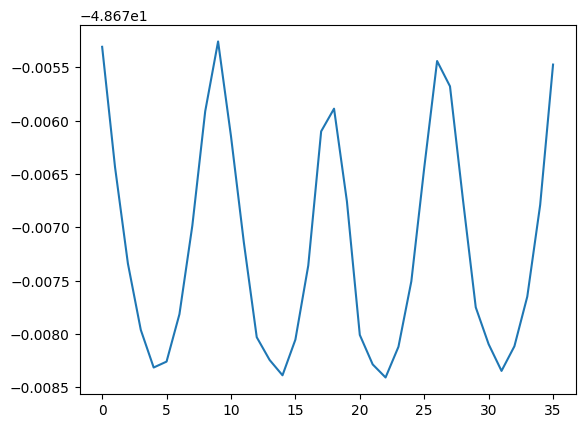

In [ ]:
from matplotlib import pyplot as plt
plt.plot(energies)

### Bond recovery

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

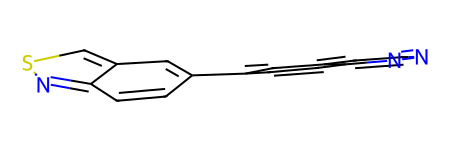

In [5]:
mol = Chem.MolFromMolFile("/home/wangxi/project/ligands_library/torsion_profiles/94_114_2_10/xtbopt.sdf")
mol